In [3]:
from experiments.cube.Cube import Cube
from hdimvis.metrics.stress.stress import vectorised_stress
from hdimvis.metrics.distance_measures.euclidian_and_manhattan import euclidean
from sklearn.decomposition import PCA
from hdimvis.algorithms.stochastic_ntet_algo.SNeD import SNeD
from hdimvis.create_low_d_layout.LowDLayoutCreation import LowDLayoutCreation
from hdimvis.data_fetchers.DataFetcher import DataFetcher
from hdimvis.visualise_layouts_and_metrics.plot import show_layouts, show_generation_metrics
from hdimvis.metrics.distance_measures.euclidian_and_manhattan import manhattan
import numpy as np
import matplotlib.pyplot as plt
import os
import definitions
from time import perf_counter
import pathlib
from pathlib import Path

SyntaxError: invalid syntax (Chalmers96.py, line 45)

In [3]:
all_datasets_list = ['poker', 'mnist', 'bonds', 'coil20', 'rna N3k', 'airfoil', 'wine quality', 'fashion mnist'
                                                                                                'shuttle',
                     'flow cytometry']


In [2]:
cube = Cube(num_points=100, side=30, angle=0.4)
cube_dataset= cube.get_sample_dataset(3000)

rna_dataset = DataFetcher.fetch_data('rna N3k')
coil20_dataset = DataFetcher.fetch_data('coil20')


NameError: name 'DataFetcher' is not defined

In [5]:
names_list = ['duet', 'trio', 'quartet', 'quintet', 'sextet', 'septet', 'octet', 'nonet', 'decet',
              'undectet', 'duodecet', 'vigintet', 'quinquagintet', 'centet', 'duocentet', 'quingentet']
# ntet_sizes = [2,3,4,5,6,7,8,9,10,12,20,50,100,200,500]

In [6]:

ntet_sizes = [2,3,4]
datasets = [cube_dataset]
# datasets = [cube_dataset, rna_dataset, coil20_dataset]

results_cube = np.zeros((len(ntet_sizes), 4)) # 4 for - time, stress, average quartet stress and ntet size
results_rna = np.zeros((len(ntet_sizes), 4))
results_coli20 = np.zeros((len(ntet_sizes), 4))

results = [results_cube, results_rna, results_coli20]
num_repeats = 2

####################
A 2D layout of the "3d cube of 30^3 points - 3000 points sampled" dataset will be created 
using the "Stochastic N-tet Descent MDS" algorithm
####################
The HD distance measure used is: euclidean
####################
"Average quartet stress" will be measured every 3 iterations
####################
"Stress" will be measured every 3 iterations
####################
All stress calculations will be performed using the euclidian norm
####################
 "N-tet" size: 2

 Vectorised euclidean stress 


 Vectorised euclidean stress 


 Vectorised euclidean stress 


 Vectorised euclidean stress 


 Vectorised euclidean stress 

####################
A 2D layout of the "3d cube of 30^3 points - 3000 points sampled" dataset will be created 
using the "Stochastic N-tet Descent MDS" algorithm
####################
The HD distance measure used is: euclidean
####################
"Average quartet stress" will be measured every 3 iterations
####################
"Stress" 

C:\Users\Owner\Desktop\2095736w\hdimvis\visualise_layouts_and_metrics\plot.py:66: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axis.scatter(x, y, alpha=alpha, s=size, c=colors, cmap=cmap)


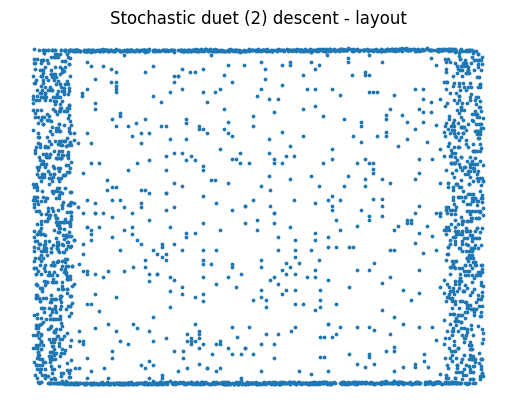

####################
A 2D layout of the "3d cube of 30^3 points - 3000 points sampled" dataset will be created 
using the "Stochastic N-tet Descent MDS" algorithm
####################
The HD distance measure used is: euclidean
####################
"Average quartet stress" will be measured every 3 iterations
####################
"Stress" will be measured every 3 iterations
####################
All stress calculations will be performed using the euclidian norm
####################
 "N-tet" size: 3

 Vectorised euclidean stress 


 Vectorised euclidean stress 


 Vectorised euclidean stress 


 Vectorised euclidean stress 


 Vectorised euclidean stress 

####################
A 2D layout of the "3d cube of 30^3 points - 3000 points sampled" dataset will be created 
using the "Stochastic N-tet Descent MDS" algorithm
####################
The HD distance measure used is: euclidean
####################
"Average quartet stress" will be measured every 3 iterations
####################
"Stress" 

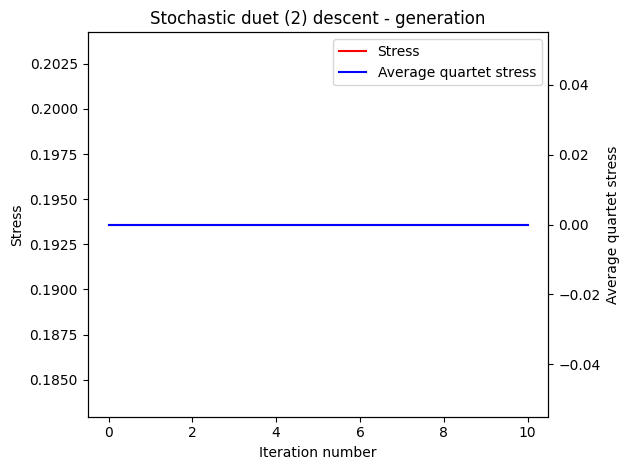

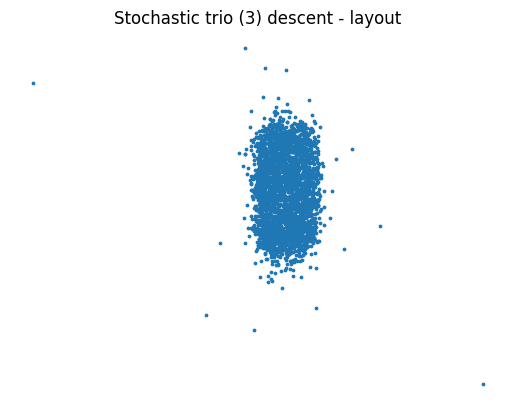

####################
A 2D layout of the "3d cube of 30^3 points - 3000 points sampled" dataset will be created 
using the "Stochastic N-tet Descent MDS" algorithm
####################
The HD distance measure used is: euclidean
####################
"Average quartet stress" will be measured every 3 iterations
####################
"Stress" will be measured every 3 iterations
####################
All stress calculations will be performed using the euclidian norm
####################
 "N-tet" size: 4

 Vectorised euclidean stress 


 Vectorised euclidean stress 


 Vectorised euclidean stress 


 Vectorised euclidean stress 


 Vectorised euclidean stress 

####################
A 2D layout of the "3d cube of 30^3 points - 3000 points sampled" dataset will be created 
using the "Stochastic N-tet Descent MDS" algorithm
####################
The HD distance measure used is: euclidean
####################
"Average quartet stress" will be measured every 3 iterations
####################
"Stress" 

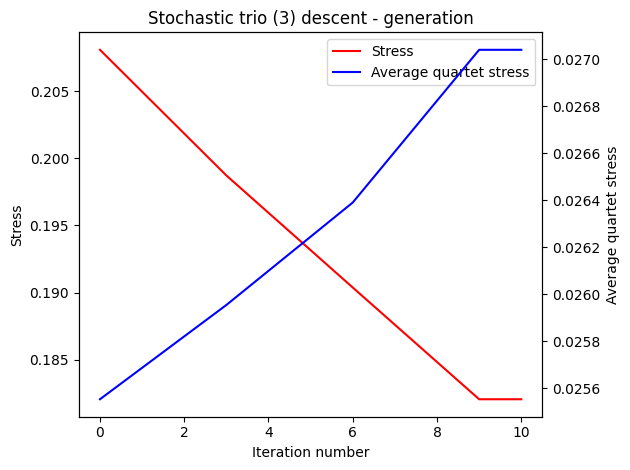

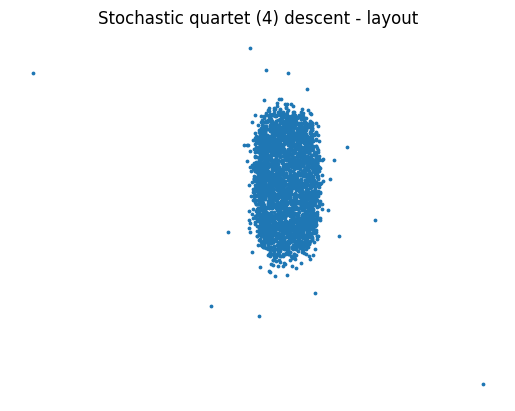

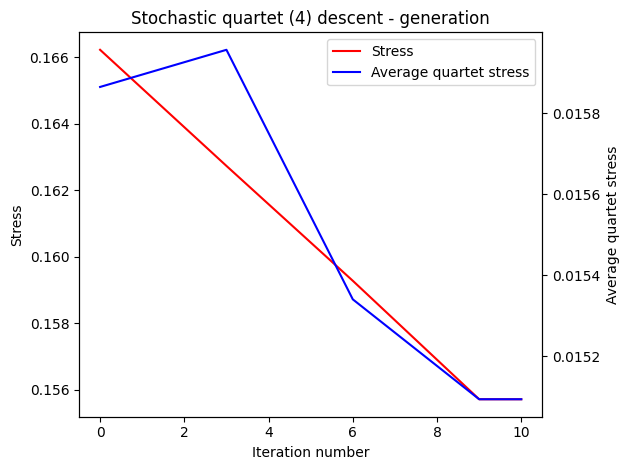

In [10]:
metric_collection = {'Average quartet stress': 3, 'Stress': 3}

for i, dataset in enumerate(datasets):

    output_dir= (Path(definitions.PROJECT_ROOT).joinpath(
    Path(f"experiments/stochastic_ntet_descent/out/{dataset.name}/"))).resolve()
    os.mkdir(output_dir)


    Xld = PCA(n_components=2, whiten=False, copy=True).fit_transform(dataset.data).astype(np.float64)
    Xld *= 10/np.std(Xld)

    for j, size in enumerate(ntet_sizes):
        time = 0
        stress = 0
        average_quartet_stress = 0

        for k in range(num_repeats):
            squad = SNeD(dataset=datasets[i], initial_layout=Xld, ntet_size=size)
            start = perf_counter()
            layout = LowDLayoutCreation().create_layout(squad, optional_metric_collection=metric_collection, no_iters=10)

            time += (start - perf_counter())
            stress += layout.collected_metrics['Stress'][1][-1]
            average_quartet_stress += layout.collected_metrics['Average quartet stress'][1][-1]

        results[i][j][0] = time/num_repeats
        results[i][j][1] = stress/num_repeats
        results[i][j][2] = average_quartet_stress/num_repeats

        print(layout.collected_metrics)
        show_layouts(layout, use_labels=True, color_map='rainbow', title=f"Stochastic {names_list[j]} ({size}) descent - layout", save_to=output_dir)
        show_generation_metrics(layout, quartet_stress=True, title= f"Stochastic {names_list[j]} ({size}) descent - generation", save_to=output_dir)

